In [1]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from torch.utils.data import ConcatDataset
from skimage.feature import local_binary_pattern
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [2]:
IMG_HEIGHT = 48
IMG_WIDTH = 48

# Path to the training data
TRAIN_DATA_PATH = os.path.join(os.getcwd(), '../FER with DL/data', 'train')

# Path to the test data
TEST_DATA_PATH = os.path.join(os.getcwd(), '../FER with DL/data', 'test')

# Define your transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

# Load the datasets
train_dataset = ImageFolder(TRAIN_DATA_PATH, transform=transform)
test_dataset = ImageFolder(TEST_DATA_PATH, transform=transform)

# Create the dataloader for validation set only, train data still needs to be augmented
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
# Takes roughly 4 minutes to run this cell

# Oversampling the disgust samples since we don't have many samples

# Define additional transformations for data augmentation
augment_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Create a new dataset with only the "disgust" images
disgust_dataset = [img for img in train_dataset if img[1]
                   == train_dataset.class_to_idx['disgust']]

In [4]:
# Convert Tensor to PIL Image
to_pil = ToPILImage()

# Apply data augmentation to the "disgust" images
augmented_disgust_dataset = [(augment_transform(to_pil(img[0])), img[1])
                             for _ in range(8) for img in disgust_dataset]

In [5]:
# Combine the original dataset with the augmented "disgust" images
train_dataset = ConcatDataset([train_dataset, augmented_disgust_dataset])

# Update the train DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Print details about the train and test datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 32197
Number of testing samples: 7178


In [6]:
def extract_features_and_labels(data_loader):
    # Parameters for LBP
    radius = 3
    n_points = 8 * radius
    # Initialize an empty list to store the feature vectors
    features = []
    labels = []
    # Process each batch of images
    for images, batch_labels in data_loader:
        # Process each image in the batch
        for i in range(len(images)):
            image = images[i].numpy().squeeze()
            # Apply LBP
            lbp = local_binary_pattern(image, n_points, radius)
            # Flatten the LBP image and add it to the list of feature vectors
            features.append(lbp.ravel())
            # Add the corresponding label to the labels list
            labels.append(batch_labels[i].item())
    return features, labels

In [7]:
# Takes roughly 4 minutes to run this cell
X_train, y_train = extract_features_and_labels(train_loader)

c:\Users\Stekunda\anaconda3\envs\DA515\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [8]:
# Takes roughly 1 minute to run this cell
X_test, y_test = extract_features_and_labels(test_loader)

In [9]:

print(f"Number of feature vectors: {len(X_train)}")
print(f"Shape of a feature vector: {X_train[0].shape}")


Number of feature vectors: 32197
Shape of a feature vector: (2304,)


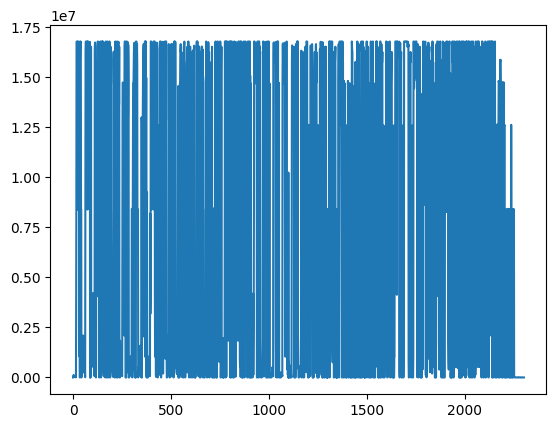

In [10]:
import matplotlib.pyplot as plt

# Plot the first feature vector
plt.plot(X_train[0])
plt.show()

In [11]:
# Create a SVM (Support Vector Machine) classifier
clf = svm.SVC()

# Train the classifier with the training data and labels
clf.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100}%")